In [1]:
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator, griddata

from scipy.spatial import KDTree

import numpy as np


from datetime import datetime
from tqdm.auto import tqdm
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from utility_programs.read_routines import SAMI


from interpolate_outputs import gps_to_ecef_custom

import matplotlib.pyplot as plt

import gc

/glade/work/abukowski/conda-envs/SAMI3-GITM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
samipath = '/glade/u/home/abukowski/scratch/simstorm-20110521/ut_onset_18/sami-gitm-coupled/'

In [3]:
nz, nf, nlt, nt=SAMI.get_grid_elems_from_parammod(samipath)
old_shape=[nlt, nf, nz]

In [4]:
grid=SAMI.get_sami_grid(samipath, nlt, nf, nz)

In [5]:
data, times=SAMI.read_to_nparray(
                samipath, datetime(2011,5,20), cols='edens', pbar=True,
                dtime_storm_start=datetime(2011,5,21,12),
                skip_time_check=True, hrs_before_storm=1, hrs_after_storm=1)

reading SAMI data: 624it [00:06, 103.31it/s]                      


In [6]:
incart = gps_to_ecef_custom(grid['glon'].flatten(), grid['glat'].flatten(), grid['alt'].flatten()).T

In [7]:
tree = KDTree(incart)

## Support

In [8]:
def make_outcart(lat, lon, alt):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    alt = np.asarray(alt)
    
    outlat, outlon, outalt = np.meshgrid(lat, lon, alt)
    
    return gps_to_ecef_custom(outlon.flatten(), outlat.flatten(), outalt.flatten()).T

In [70]:
def interpolate_pts(nearest, old_shape, in_cart, out_cart, data, t, method=None, num_pts=1, col='edens'):
    
    interpd = []
    
    nlt, nf, nz = old_shape

    for numpt, nearest_pt in enumerate(tqdm(nearest)):

        lt0, f0, z0 = np.unravel_index(nearest_pt, old_shape)

        nzs, nfs, nlts = np.meshgrid(np.arange(z0-num_pts, z0+num_pts+1),
                                      np.arange(f0-num_pts, f0+num_pts+1),
                                      np.arange(lt0-num_pts, lt0+num_pts+1))
        
        
#         nzs, nfs, nlts = np.meshgrid([z0-1, z0, z0+1], [f0-1, f0, f0+1], [lt0-1, lt0, lt0+1])
#                                       # np.arange(f0-num_pts, f0+num_pts+1),
#                                       # np.arange(lt0-num_pts, lt0+num_pts+1))

    
        nzs = nzs.flatten()
        nfs = nfs.flatten()
        nlts = nlts.flatten()

        nlts = [i if i <= nlt-1 else nlt-i for i in nlts]
        nfs = [i if i <= nf-1 else nf-i for i in nfs]
        nzs = [i if i <= nz-1 else nz-i for i in nzs]

        cart_ids = np.ravel_multi_index([nlts, nfs, nzs], old_shape, 'wrap')
        
        if method=='LND':

            interpr = LinearNDInterpolator(in_cart[cart_ids], data['data'][col][nlts, nfs, nzs, t])
            interpd.append(interpr(out_cart[numpt]))

        if method=='IDW':
            d2ps = np.sqrt(np.sum((in_cart[cart_ids] - out_cart[numpt])**2, axis=1))
            weights = 1/(d2ps)
            interpd.append(np.sum(weights * data['data'][col][nlts, nfs, nzs, t]) / np.sum(weights))

    return np.array(interpd).flatten()

# Set up a grid and look into some things...

In [10]:

lats = np.arange(-90,90,1)
lons = np.arange(0,360,4)
alts = 450

t = 20


In [11]:
outcart = make_outcart(lats, lons, alts)

In [131]:
dists, nearest = tree.query(outcart)

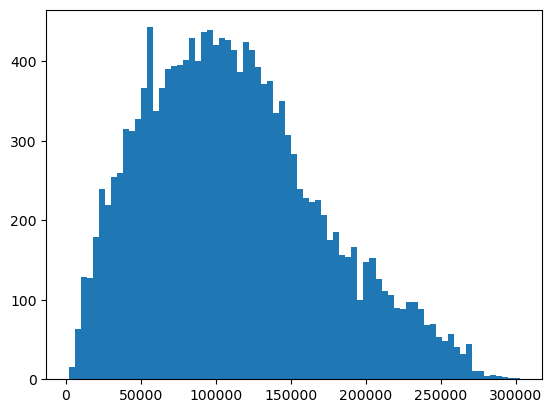

In [13]:
plt.hist(dists, bins=75);

In [14]:
dists.reshape([len(lons), len(lats)])

array([[ 55372.71348295,  81142.64690069, 155936.96748393, ...,
         96754.14253958, 134400.25729552, 150051.63718658],
       [ 55372.71348295,  74563.22536207, 151150.76477724, ...,
         75552.23012382, 118557.03279985, 141882.04794309],
       [ 55372.71348295,  68006.2112145 , 135340.92850405, ...,
         58873.07859815, 103447.98209959, 133873.1638196 ],
       ...,
       [ 55372.71348295, 100713.92997035, 115245.45326989, ...,
        169044.32187233, 166530.55608543, 174954.85112512],
       [ 55372.71348295,  94241.90188388, 130554.05924972, ...,
        144302.48164941, 167205.50845652, 166636.22044407],
       [ 55372.71348295,  87710.98809745, 146404.56560343, ...,
        120032.97507829, 150681.57648635, 158320.36981418]])

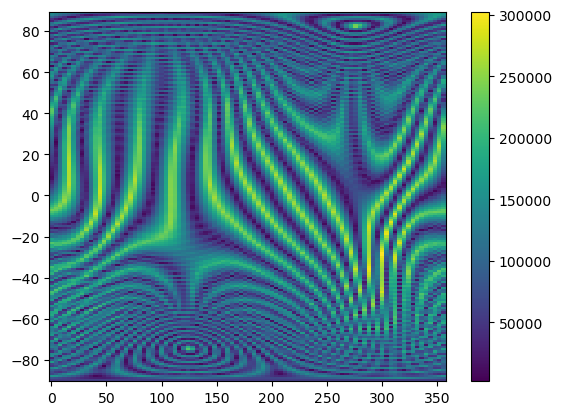

In [15]:
plt.pcolormesh(lons, lats, dists.reshape([len(lons), len(lats)]).T)

plt.colorbar()

plt.show()


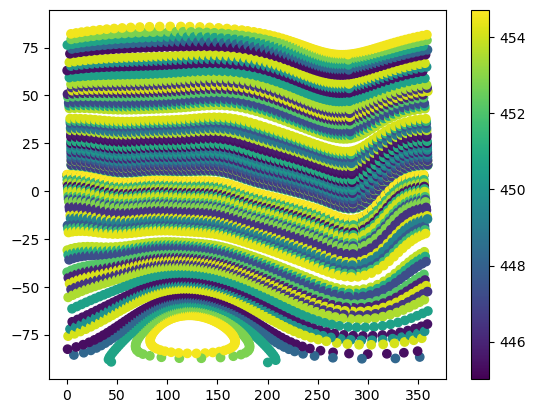

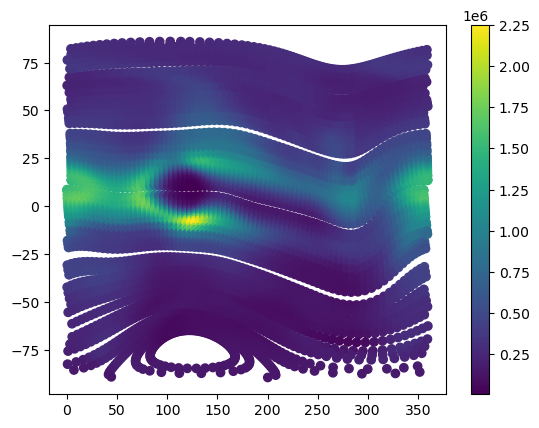

In [16]:
ma = np.where(np.abs(grid['alt'] - alts) < 5)
plt.scatter(grid['glon'][ma].flatten(), grid['glat'][ma].flatten(), c=grid['alt'][ma])
plt.colorbar()
plt.show()


ma = np.where(np.abs(grid['alt'] - alts) < 5)
plt.scatter(grid['glon'][ma].flatten(), grid['glat'][ma].flatten(), c=data['data']['edens'][:, :, :, t][ma])
plt.colorbar()
plt.show()

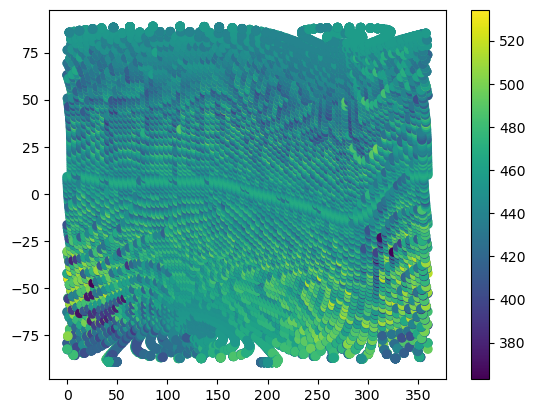

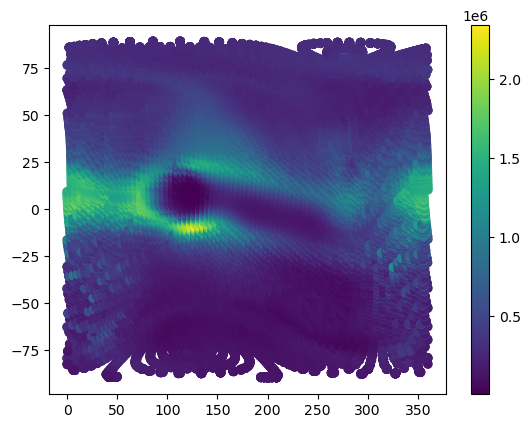

In [17]:
# ma = np.where(np.abs(grid['alt'] - alts) < 2)
plt.scatter(grid['glon'].flatten()[nearest], grid['glat'].flatten()[nearest], c=grid['alt'].flatten()[nearest])
plt.colorbar()

plt.show()


plt.scatter(grid['glon'].flatten()[nearest], grid['glat'].flatten()[nearest], c=data['data']['edens'][:,:,:,t].flatten()[nearest])
plt.colorbar()

plt.show()

In [18]:
lnd_1 = interpolate_pts(nearest, old_shape, incart, outcart, data, t, method='LND', num_pts=1)
lnd_2 = interpolate_pts(nearest, old_shape, incart, outcart, data, t, method='LND', num_pts=2)
lnd_3 = interpolate_pts(nearest, old_shape, incart, outcart, data, t, method='LND', num_pts=3)

100%|██████████| 16200/16200 [03:24<00:00, 79.35it/s]


In [20]:
idw_1 = interpolate_pts(nearest, old_shape, incart, outcart, data, t, method='IDW', num_pts=1)
idw_2 = interpolate_pts(nearest, old_shape, incart, outcart, data, t, method='IDW', num_pts=2)
idw_3 = interpolate_pts(nearest, old_shape, incart, outcart, data, t, method='IDW', num_pts=3)

100%|██████████| 16200/16200 [00:07<00:00, 2074.47it/s]


In [25]:
altmask = np.where(np.abs(grid['alt'].flatten() - alts) < 200)

In [26]:
%time interpr = LinearNDInterpolator(incart[altmask], data['data']['edens'][:, :, :, t].flatten()[altmask])
%time LND_Full = interpr(outcart)


CPU times: user 8.68 s, sys: 248 ms, total: 8.93 s
Wall time: 8.92 s
CPU times: user 5.93 s, sys: 0 ns, total: 5.93 s
Wall time: 5.93 s


In [27]:
%time interpr = LinearNDInterpolator(incart[altmask], data['data']['edens'][:, :, :, t].flatten()[altmask], rescale=True)
%time LND_Full_rescale = interpr(outcart)

CPU times: user 8.88 s, sys: 123 ms, total: 9 s
Wall time: 9 s
CPU times: user 5.91 s, sys: 0 ns, total: 5.91 s
Wall time: 5.91 s


In [28]:
LND_Full.shape

(16200,)

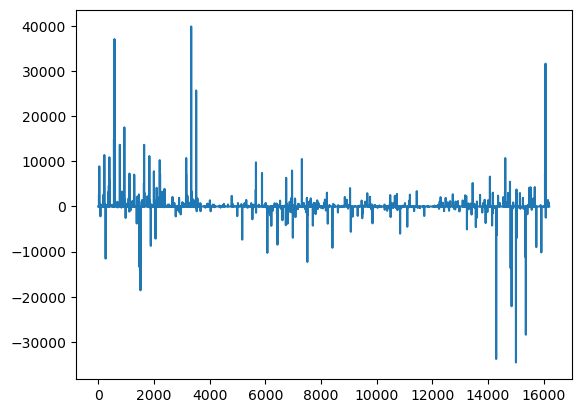

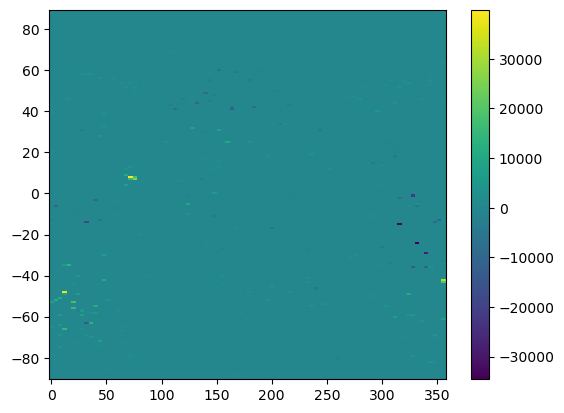

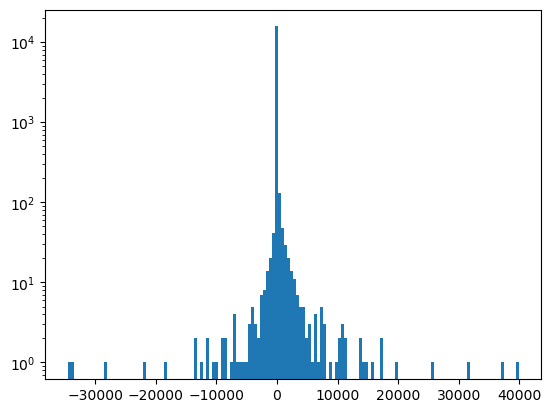

In [33]:
plt.plot(LND_Full - LND_Full_rescale)
plt.show()

plt.pcolormesh(lons, lats, (LND_Full - LND_Full_rescale).reshape([len(lons), len(lats)]).T)
plt.colorbar()
plt.show()

plt.hist(LND_Full - LND_Full_rescale, bins=150)
plt.yscale('log');

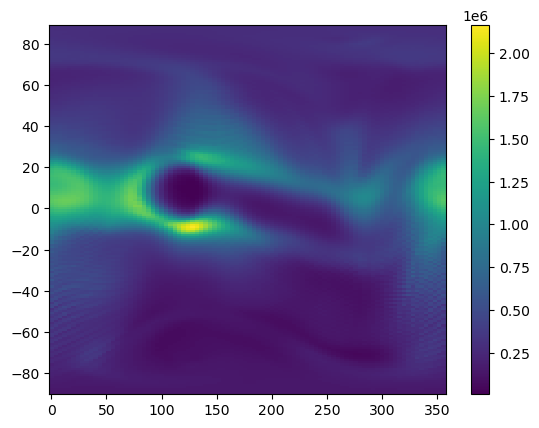

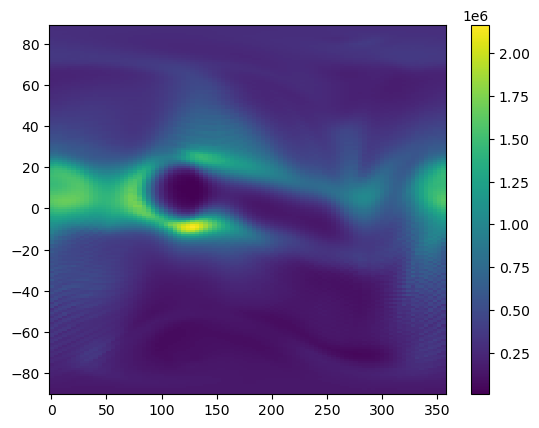

In [38]:
plt.pcolormesh(lons, lats, LND_Full.reshape([len(lons), len(lats)]).T)
plt.colorbar()
plt.show()
plt.pcolormesh(lons, lats, LND_Full_rescale.reshape([len(lons), len(lats)]).T)
plt.colorbar()
plt.show()

plt.pcolormesh(lons, lats, LND_Full.reshape([len(lons), len(lats)]).T)
plt.colorbar()
plt.show()
plt.pcolormesh(lons, lats, LND_Full_rescale.reshape([len(lons), len(lats)]).T)
plt.colorbar()
plt.show()

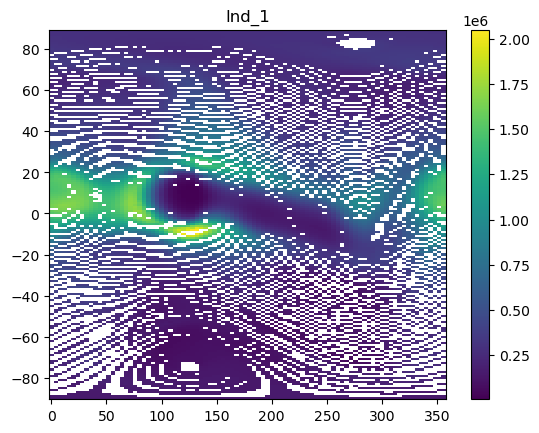

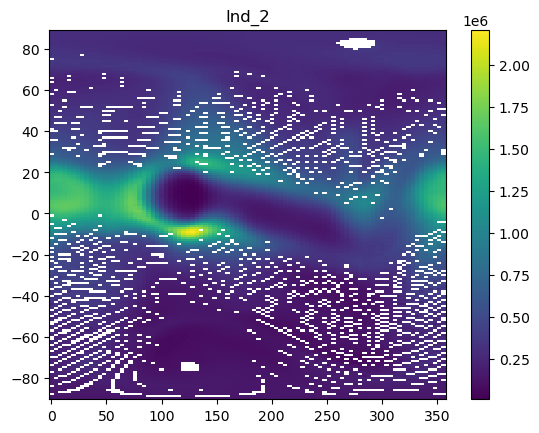

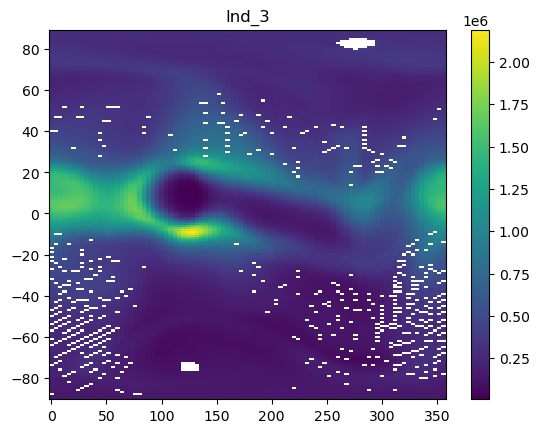

In [35]:
plt.pcolormesh(lons, lats, lnd_1.reshape([len(lons), len(lats)]).T)
plt.title('lnd_1')
plt.colorbar()
plt.show()
plt.pcolormesh(lons, lats, lnd_2.reshape([len(lons), len(lats)]).T)
plt.title('lnd_2')
plt.colorbar()
plt.show()
plt.pcolormesh(lons, lats, lnd_3.reshape([len(lons), len(lats)]).T)
plt.title('lnd_3')
plt.colorbar()
plt.show()

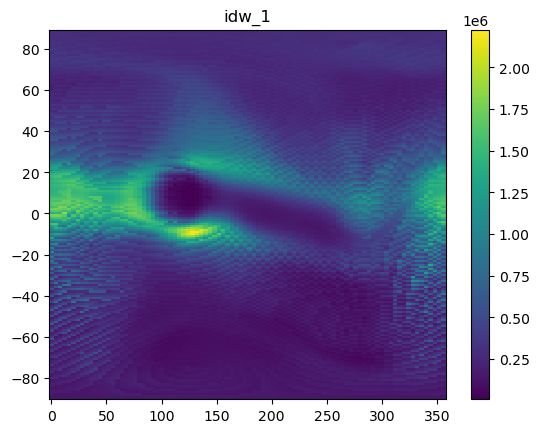

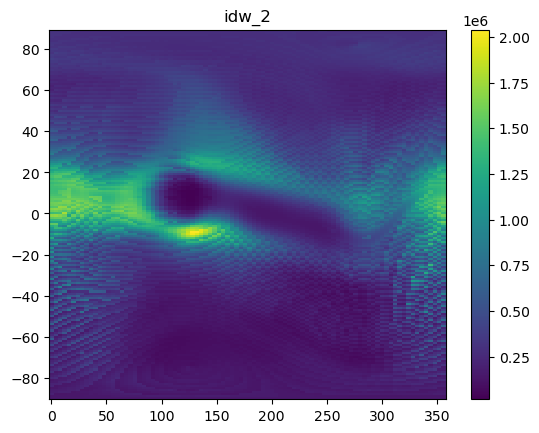

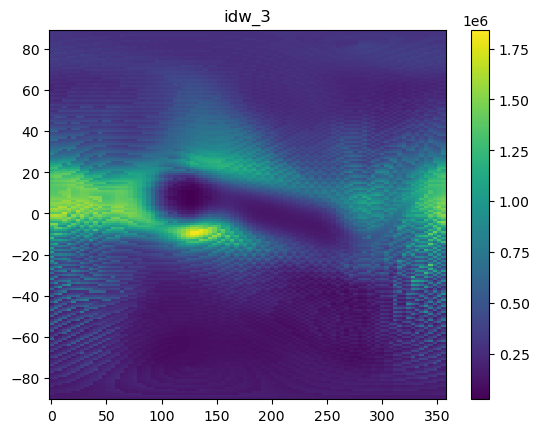

In [39]:
plt.pcolormesh(lons, lats, idw_1.reshape([len(lons), len(lats)]).T)
plt.title('idw_1')
plt.colorbar()
plt.show()
plt.pcolormesh(lons, lats, idw_2.reshape([len(lons), len(lats)]).T)
plt.title('idw_2')
plt.colorbar()
plt.show()
plt.pcolormesh(lons, lats, idw_3.reshape([len(lons), len(lats)]).T)
plt.title('idw_3')
plt.colorbar()
plt.show()

In [133]:
while True:
    r = np.random.randint(len(lnd_3))
    if np.isnan(lnd_3)[r]:
        print(r)
        break

16065


In [134]:
outcart[r]

array([ 4824009.19159437,  -337327.58355439, -4805546.46039987])

In [135]:
d, i = tree.query(outcart[r])
d, i

(159124.5999673063, 234542)

In [136]:
idx = np.unravel_index(i, old_shape)

In [137]:
xs, ys, zs = np.meshgrid(np.arange(idx[0]-2, idx[0]+3),
                         np.arange(idx[1]-2, idx[1]+3),
                         np.arange(idx[2]-2, idx[2]+3))

cart_ids = np.ravel_multi_index([xs, ys, zs], old_shape, 'wrap')

In [138]:
xyz = incart[cart_ids.flatten()]

In [139]:
xyz.shape

(125, 3)

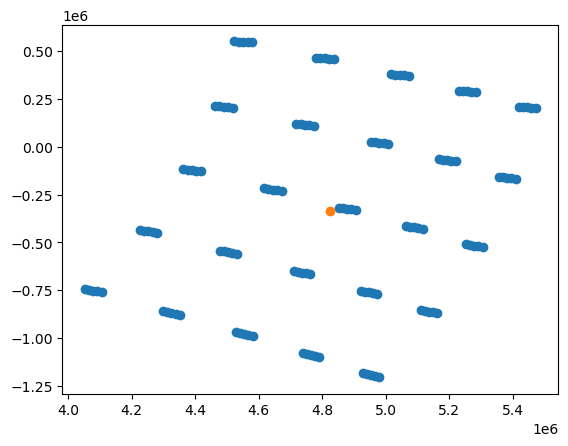

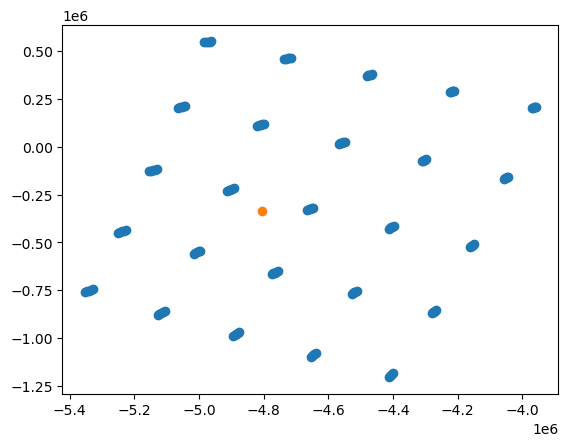

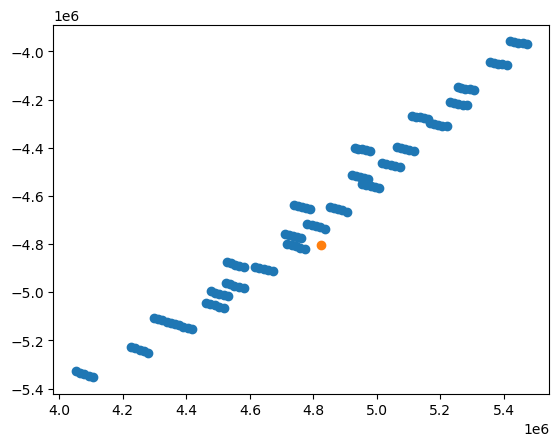

In [142]:
plt.scatter(xyz[:,0], xyz[:,1])
plt.scatter(outcart[r][0], outcart[r][1])
plt.show()

plt.scatter(xyz[:,2], xyz[:,1])
plt.scatter(outcart[r][2], outcart[r][1])
plt.show()

plt.scatter(xyz[:,0], xyz[:,2])
plt.scatter(outcart[r][0], outcart[r][2])
plt.show()


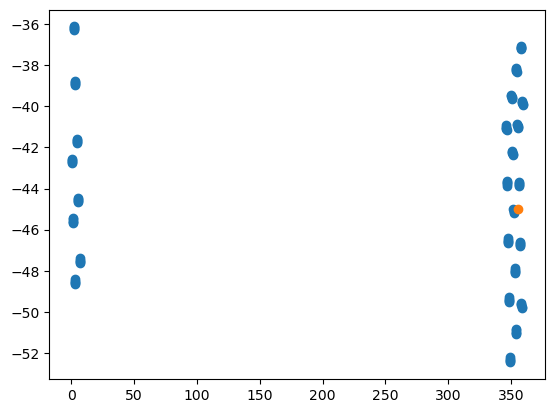

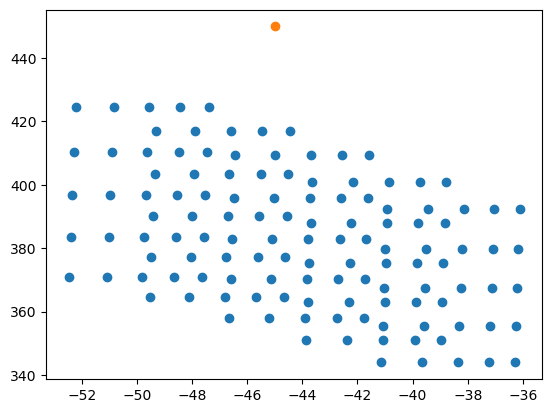

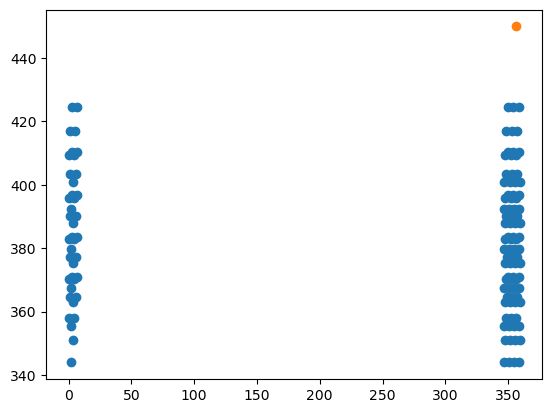

In [143]:
lon, lat, alt = [grid['glon'].flatten()[cart_ids],
       grid['glat'].flatten()[cart_ids],
       grid['alt'].flatten()[cart_ids]]

outlat, outlon, outalt = np.meshgrid(lats, lons, alts)
outlat=outlat.flatten()
outlon=outlon.flatten()
outalt=outalt.flatten()

plt.scatter(lon, lat)
plt.scatter(outlon[r], outlat[r])
plt.show()

plt.scatter(lat, alt)
plt.scatter(outlat[r], outalt[r])
plt.show()

plt.scatter(lon, alt)
plt.scatter(outlon[r], outalt[r])
plt.show()

## Now how does the regular sami interpolator handle things

In [145]:
SAMI = importlib.reload(SAMI)

In [147]:
tecdata = SAMI.read_sami_dene_tec_MAG_GRID(samipath)

In [151]:
tecdata['data'].keys()

dict_keys(['edens', 'tec'])

In [158]:
nalt = np.argmin(np.abs(tecdata['grid']['alt'] - alts))
len(tecdata['grid']['alt'])

100

In [157]:
tecdata['data']['edens'].shape

(625, 80, 100, 100)

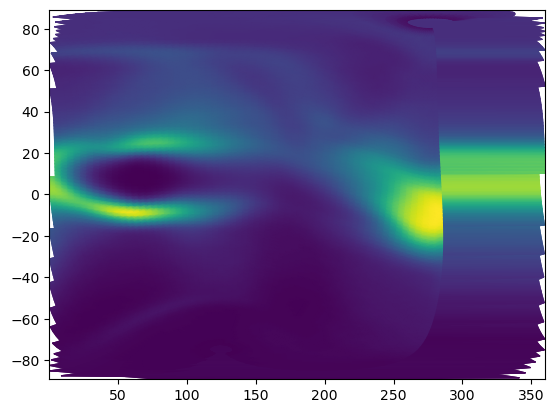

In [172]:
plt.pcolormesh(tecdata['grid']['glon'][:, nalt, :], tecdata['grid']['glat'][:, nalt, :], tecdata['data']['edens'][500, :, nalt, :], shading ='gouraud')

In [170]:
tecdata['grid'].keys()

dict_keys(['glat', 'glon', 'alt', 'mlat', 'mlon', 'malt'])